In [10]:
import xarray as xr
import pandas as pd
import numpy as np
import s3fs
import os
import gcsfs
from pathlib import Path

import gcsfs
from pyproj import Transformer
import matplotlib.pyplot as plt

SCRATCH_BUCKET = "gs://leap-scratch/zero734kr"

OUT_PREFIX = f"{SCRATCH_BUCKET.rstrip('/')}/sfincs_soundview_preproc"
gcs_path = f"{OUT_PREFIX}/forcing/sfincs.dis"

print(f"Output prefix: {OUT_PREFIX}")

Output prefix: gs://leap-scratch/zero734kr/sfincs_soundview_preproc


In [13]:
# Load discharge data
df_raw = pd.read_csv("daily.csv")

print(f"Shape: {df_raw.shape}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nData info:")
print(df_raw.info())
print(f"\nFirst rows:")
df_raw.head()

Shape: (365, 13)

Columns: ['x', 'y', 'id', 'time_series_id', 'monitoring_location_id', 'parameter_code', 'statistic_id', 'time', 'value', 'unit_of_measure', 'approval_status', 'qualifier', 'last_modified']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   x                       365 non-null    float64
 1   y                       365 non-null    float64
 2   id                      365 non-null    object 
 3   time_series_id          365 non-null    object 
 4   monitoring_location_id  365 non-null    object 
 5   parameter_code          365 non-null    int64  
 6   statistic_id            365 non-null    int64  
 7   time                    365 non-null    object 
 8   value                   365 non-null    float64
 9   unit_of_measure         365 non-null    object 
 10  approval_status         365 non-nul

,x,y,id,time_series_id,monitoring_location_id,parameter_code,statistic_id,time,value,unit_of_measure,approval_status,qualifier,last_modified
0,-73.874389,40.862306,1feb1696-4d9f-44fa-b923-a28633de1efd,29178f5edda94a529bcdcecba5f1d2f9,USGS-01302020,60,3,2026-01-15,26.3,ft^3/s,Provisional,NaN,2026-01-16 07:10:01.063469+00:00
1,-73.874389,40.862306,1a329669-846b-4d5c-a01b-5b3c355da960,29178f5edda94a529bcdcecba5f1d2f9,USGS-01302020,60,3,2026-01-14,27.1,ft^3/s,Provisional,NaN,2026-01-15 13:59:15.793370+00:00
2,-73.874389,40.862306,11d7ed99-b8d2-4b46-a83f-bb90facf465a,29178f5edda94a529bcdcecba5f1d2f9,USGS-01302020,60,3,2026-01-13,28.0,ft^3/s,Provisional,NaN,2026-01-14 09:03:41.487928+00:00
3,-73.874389,40.862306,19feef3f-20de-4b63-85ce-37b1b9fcbd8b,29178f5edda94a529bcdcecba5f1d2f9,USGS-01302020,60,3,2026-01-12,31.1,ft^3/s,Provisional,NaN,2026-01-13 09:01:12.357124+00:00
4,-73.874389,40.862306,e930e467-e0f9-4218-9bd9-759ca2834b81,29178f5edda94a529bcdcecba5f1d2f9,USGS-01302020,60,3,2026-01-11,62.4,ft^3/s,Provisional,NaN,2026-01-12 08:59:44.414085+00:00


In [14]:
# What gauge is this?
print("Gauge Information:")
print(f"  ID: {df_raw['monitoring_location_id'].iloc[0]}")
print(f"  Parameter: {df_raw['parameter_code'].iloc[0]} (00060 = Discharge/Streamflow)")
print(f"  Units: {df_raw['unit_of_measure'].iloc[0]}")
print(f"  Location: ({df_raw['y'].iloc[0]:.6f}°N, {df_raw['x'].iloc[0]:.6f}°W)")
print(f"\n  This is: Bronx River at Bronx, NY")

# Check time range
df_raw['datetime'] = pd.to_datetime(df_raw['time'])
print(f"\nTime range in data:")
print(f"  Start: {df_raw['datetime'].min()}")
print(f"  End: {df_raw['datetime'].max()}")
print(f"  Records: {len(df_raw)}")

Gauge Information:
  ID: USGS-01302020
  Parameter: 60 (00060 = Discharge/Streamflow)
  Units: ft^3/s
  Location: (40.862306°N, -73.874389°W)

  This is: Bronx River at Bronx, NY

Time range in data:
  Start: 2025-01-16 00:00:00
  End: 2026-01-15 00:00:00
  Records: 365


In [15]:
# Gauge location in lat/lon
gauge_lon = df_raw['x'].iloc[0]  # -73.874...
gauge_lat = df_raw['y'].iloc[0]  # 40.862...

print(f"Gauge location (WGS84):")
print(f"  Latitude:  {gauge_lat:.6f}°")
print(f"  Longitude: {gauge_lon:.6f}°")

# Convert to UTM Zone 18N (EPSG:26918) - required by SFINCS
transformer = Transformer.from_crs("EPSG:4326", "EPSG:26918", always_xy=True)
gauge_x_utm, gauge_y_utm = transformer.transform(gauge_lon, gauge_lat)

print(f"\nGauge location (UTM Zone 18N):")
print(f"  X (Easting):  {gauge_x_utm:.2f} meters")
print(f"  Y (Northing): {gauge_y_utm:.2f} meters")

# This will go in sfincs.src file

Gauge location (WGS84):
  Latitude:  40.862306°
  Longitude: -73.874389°

Gauge location (UTM Zone 18N):
  X (Easting):  594863.24 meters
  Y (Northing): 4524081.59 meters


In [16]:
# Filter to our time range
df_filtered = df_raw[
    (df_raw['datetime'] >= TIME_START) & 
    (df_raw['datetime'] <= TIME_END)
].copy()

print(f"Filtered to {TIME_START} - {TIME_END}")
print(f"  Records: {len(df_filtered)}")

if len(df_filtered) == 0:
    print("\n⚠️  No data in requested range!")
    print(f"Available: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")
    # Use all available data instead
    df_filtered = df_raw.copy()
    TIME_START = df_filtered['datetime'].min()
    TIME_END = df_filtered['datetime'].max()
    print(f"Using: {TIME_START} to {TIME_END}")

# Sort by time
df_filtered = df_filtered.sort_values('datetime').reset_index(drop=True)

# Convert units: ft³/s -> m³/s
# 1 cubic foot per second = 0.0283168 cubic meters per second
df_filtered['discharge_m3s'] = df_filtered['value'] * 0.0283168

print(f"\nDischarge statistics:")
print(f"  Mean: {df_filtered['discharge_m3s'].mean():.3f} m³/s ({df_filtered['value'].mean():.1f} ft³/s)")
print(f"  Max:  {df_filtered['discharge_m3s'].max():.3f} m³/s ({df_filtered['value'].max():.1f} ft³/s)")
print(f"  Min:  {df_filtered['discharge_m3s'].min():.3f} m³/s ({df_filtered['value'].min():.1f} ft³/s)")

Filtered to 2023-01-01 - 2025-12-31
  Records: 350

Discharge statistics:
  Mean: 1.430 m³/s (50.5 ft³/s)
  Max:  19.737 m³/s (697.0 ft³/s)
  Min:  0.323 m³/s (11.4 ft³/s)


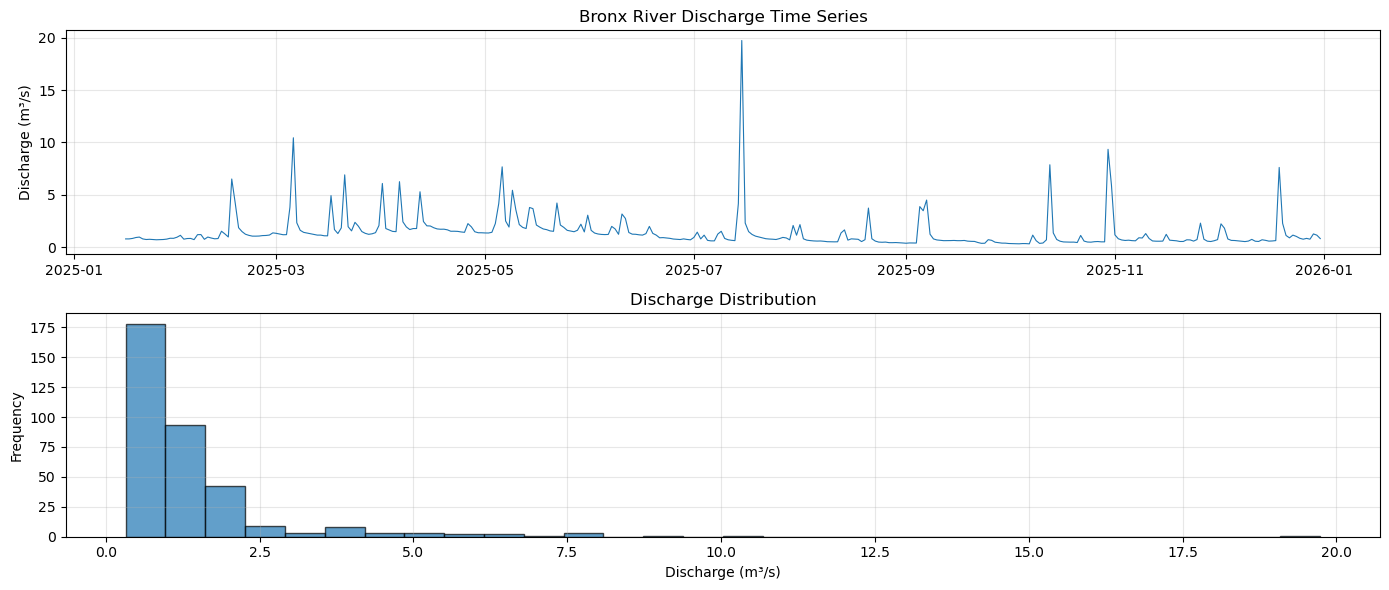


Top 5 discharge events:
  datetime  discharge_m3s  value
2025-07-15      19.736810  697.0
2025-03-06      10.448899  369.0
2025-10-30       9.344544  330.0
2025-10-13       7.872070  278.0
2025-05-06       7.673853  271.0


In [17]:
# Plot the time series
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Plot 1: Full time series
axes[0].plot(df_filtered['datetime'], df_filtered['discharge_m3s'], linewidth=0.8)
axes[0].set_ylabel('Discharge (m³/s)')
axes[0].set_title('Bronx River Discharge Time Series')
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram
axes[1].hist(df_filtered['discharge_m3s'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Discharge (m³/s)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Discharge Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find peak events
top_events = df_filtered.nlargest(5, 'discharge_m3s')[['datetime', 'discharge_m3s', 'value']]
print("\nTop 5 discharge events:")
print(top_events.to_string(index=False))